RUNNING L-BFGS-B...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.97101D-01    |proj g|=  1.00334D-03

At iterate    1    f= -9.97147D-01    |proj g|=  9.92406D-04

At iterate    2    f= -9.99955D-01    |proj g|=  1.33471D-04

At iterate    3    f= -9.99991D-01    |proj g|=  7.16316D-05

At iterate    4    f= -9.99998D-01    |proj g|=  1.17151D-04

At iterate    5    f= -1.00000D+00    |proj g|=  4.97602D-05
Optimization done.  Final objective:
At iterate    6    f= -1.00000D+00    |proj g|=  7.39409D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


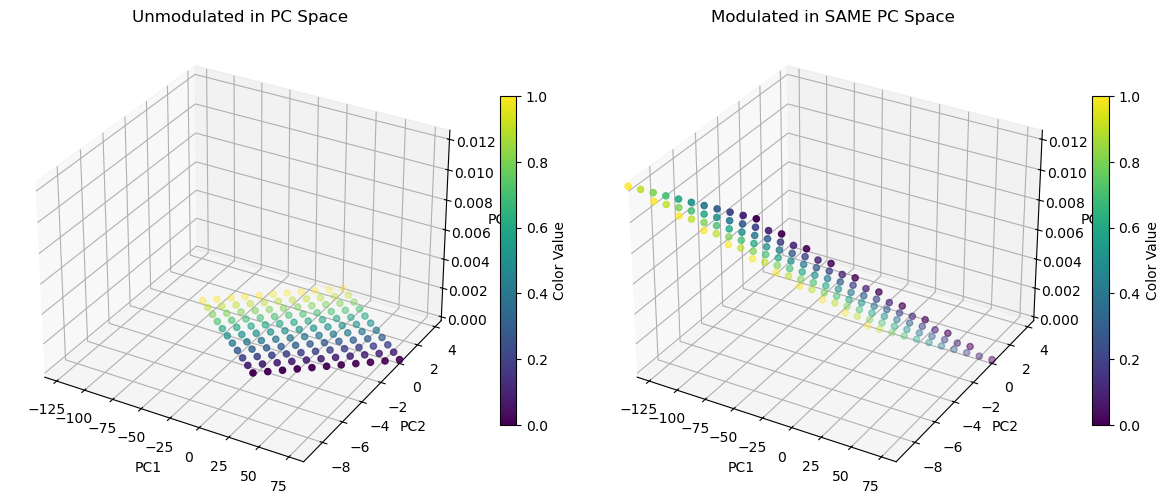

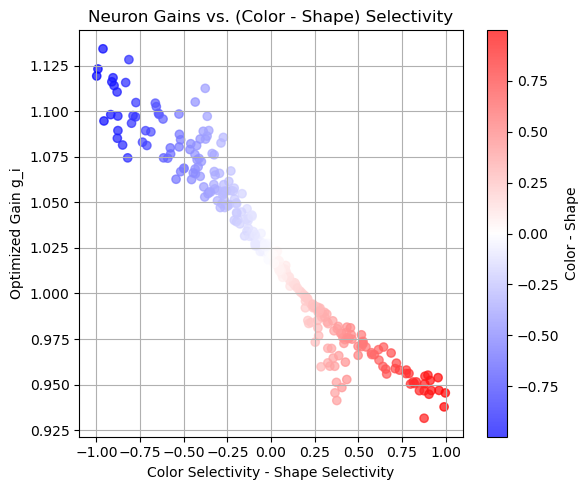

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(15)
N = 300
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# ================================================================
# MAIN SCRIPT
# ================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For coloring the grid in plots, we need to track the color param for each point
    # We'll store them in a matching shape to 'responses_grid'.
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [121,]

    # 2.1) Compute unmodulated responses for entire grid
    responses_grid_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)
    # shape => [121, N]

    # 2.2) PCA on unmodulated grid responses, keep 3 PCs
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)  # shape = [121, N]
    # We'll store the top 3 components in a matrix for easy projection:
    # pca_grid.components_ has shape [3, N], so we can do x_proj = pca_grid.components_ @ x
    # or just use 'transform' method
    # But we'll also store them individually if we want
    pc_basis = pca_grid.components_  # shape [3, N]

    # We'll define v1 as the first PC (normalized)
    v1 = pc_basis[0]
    v1 /= np.linalg.norm(v1)

    # 3) For the color-axis alignment, pick shape=0.3
    shape_for_color_line = 0.3

    def color_axis_direction(g):
        """
        For a given g-vector, define color-axis as difference between
        response at color=1.0 and color=0.0 for shape=0.3.
        """
        resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
        resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
        return resp_c1 - resp_c0

    # 4) Objective: maximize cos^2 w.r.t. v1 => minimize negative cos^2
    def alignment_objective(g):
        d_col = color_axis_direction(g)
        dot_val = np.dot(v1, d_col)
        denom = (np.linalg.norm(d_col) * np.linalg.norm(v1))
        if denom < 1e-15:
            return 0.0  # degenerate
        cos_val = dot_val / denom
        cos_val = np.clip(cos_val, -1, 1)
        return -(cos_val**2)

    # 5) Optimize over [0.8,1.2] for each neuron
    L, U = 0.80, 1.20
    bounds = [(L, U)] * N
    init_g = np.ones(N)

    print("RUNNING L-BFGS-B...")
    res = minimize(fun=alignment_objective,
                   x0=init_g,
                   method='L-BFGS-B',
                   bounds=bounds,
                   options={'maxiter': 200, 'disp': True})

    g_opt = res.x
    print("Optimization done.  Final objective:", res.fun)

    # 5.1) Compare angles pre vs. post
    def angle_with_v1(d_vec):
        dot_v = np.dot(v1, d_vec)
        denom = np.linalg.norm(v1)*np.linalg.norm(d_vec)
        if denom < 1e-15:
            return np.nan
        val = dot_v / denom
        val = np.clip(val, -1, 1)
        angle_deg = np.degrees(np.arccos(val))
        # We'll consider 0 deg vs 180 deg the same "axis" => pick smaller angle
        return min(angle_deg, 180.0 - angle_deg)

    d_unmod = color_axis_direction(init_g)
    d_mod = color_axis_direction(g_opt)

    angle_pre = angle_with_v1(d_unmod)
    angle_post = angle_with_v1(d_mod)
    print(f"Angle pre-mod = {angle_pre:.3f} deg")
    print(f"Angle post-mod = {angle_post:.3f} deg")
    print(f"Angle improvement = {angle_pre - angle_post:.3f} deg")

    # ---------------------------------------------------------
    # 6) Visualization
    #   6.1) 3D scatter: unmodulated vs modulated, each subplot in the same PC basis
    #   6.2) Another figure: (color_selectivity - shape_selectivity) vs. g_opt
    # ---------------------------------------------------------

    # 6.1) 3D scatter in the unmodulated PC space
    # Project the unmodulated grid responses and the modulated grid responses
    # into the same PCA space (the one derived from unmodulated)
    # => we can use pca_grid.transform(...) for convenience
    responses_grid_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=g_opt)
    proj_unmod = pca_grid.transform(responses_grid_unmod)  # shape [121, 3]
    proj_mod = pca_grid.transform(responses_grid_mod)      # shape [121, 3]

    # Make a 3D figure with 2 subplots side by side
    # Make a 3D figure with 2 subplots side by side
    fig = plt.figure(figsize=(12,5))

    # First subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Unmodulated in PC Space")
    sc1 = ax1.scatter(proj_unmod[:,0], proj_unmod[:,1], proj_unmod[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")

    # Second subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Modulated in SAME PC Space")
    sc2 = ax2.scatter(proj_mod[:,0], proj_mod[:,1], proj_mod[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")

    # Get the overall min and max for each dimension
    x_min = min(proj_unmod[:,0].min(), proj_mod[:,0].min())
    x_max = max(proj_unmod[:,0].max(), proj_mod[:,0].max())
    y_min = min(proj_unmod[:,1].min(), proj_mod[:,1].min())
    y_max = max(proj_unmod[:,1].max(), proj_mod[:,1].max())
    z_min = min(proj_unmod[:,2].min(), proj_mod[:,2].min())
    z_max = max(proj_unmod[:,2].max(), proj_mod[:,2].max())

    # Set the same limits for both plots
    for ax in [ax1, ax2]:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

    # Add colorbars
    cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
    cb1.set_label("Color Value")
    cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
    cb2.set_label("Color Value")

    plt.tight_layout()
    plt.show()

    # 6.2) Scatter: (color_selectivity - shape_selectivity) vs. g_opt
    color_diff = S[:,1] - S[:,0]   # for each neuron i, color_sel[i] - shape_sel[i]
    # or if you want shape minus color, reverse it

    fig2 = plt.figure(figsize=(6,5))
    plt.scatter(color_diff, g_opt, alpha=0.7, c=color_diff, cmap='bwr')
    plt.xlabel("Color Selectivity - Shape Selectivity")
    plt.ylabel("Optimized Gain g_i")
    plt.title("Neuron Gains vs. (Color - Shape) Selectivity")
    cb = plt.colorbar()
    cb.set_label("Color - Shape")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


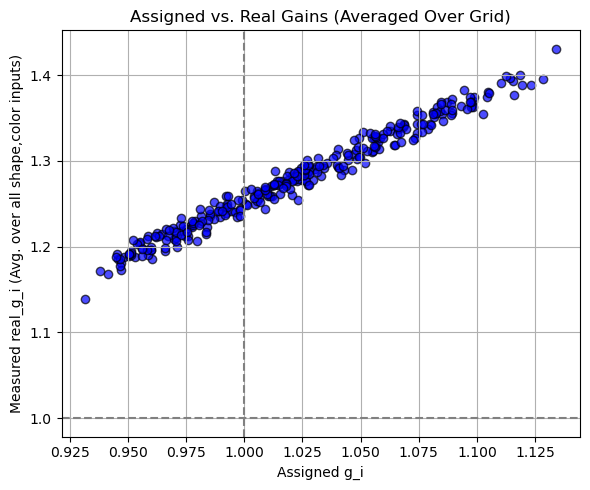

In [2]:
# ------------------------
# SNIPPET: Real g vs. Assigned g
# ------------------------

# 1) Compute the unmodulated grid responses [num_inputs, N]
r_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)

# 2) Compute the modulated grid responses [num_inputs, N]
r_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_opt)

# 3) Average over all inputs (axis=0 => average rows)
avg_unmod = np.mean(r_unmod, axis=0)  # shape [N,]
avg_mod   = np.mean(r_mod,   axis=0)  # shape [N,]

# 4) Compute real_g as ratio of mean modulated to mean unmodulated
#    If avg_unmod[i] is ~0, define real_g[i] as NaN
real_g = np.zeros_like(avg_unmod)
for i in range(len(avg_unmod)):
    if abs(avg_unmod[i]) < 1e-12:
        real_g[i] = np.nan
    else:
        real_g[i] = avg_mod[i] / avg_unmod[i]

# 5) Plot the assigned g vs. real_g
plt.figure(figsize=(6,5))
plt.scatter(g_opt, real_g, alpha=0.7, c='blue', edgecolors='k')
plt.axhline(1.0, color='gray', linestyle='--')
plt.axvline(1.0, color='gray', linestyle='--')

plt.xlabel("Assigned g_i")
plt.ylabel("Measured real_g_i (Avg. over all shape,color inputs)")
plt.title("Assigned vs. Real Gains (Averaged Over Grid)")
plt.grid(True)
plt.tight_layout()
plt.show()


RUNNING L-BFGS-B...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.97101D-01    |proj g|=  1.00321D-03

At iterate    1    f= -9.97101D-01    |proj g|=  1.87997D-03

At iterate    2    f= -9.97876D-01    |proj g|=  1.25329D-01

At iterate    3    f= -9.98155D-01    |proj g|=  2.31025D-01

At iterate    4    f= -9.98829D-01    |proj g|=  7.45939D-02

At iterate    5    f= -9.99198D-01    |proj g|=  2.62693D-02

At iterate    6    f= -9.99447D-01    |proj g|=  7.35202D-02

At iterate    7    f= -9.99601D-01    |proj g|=  9.15844D-02

At iterate    8    f= -9.99707D-01    |proj g|=  9.69491D-04

At iterate    9    f= -9.99733D-01    |proj g|=  1.75913D-02

At iterate   10    f= -9.99737D-01    |proj g|=  5.08642D-03

At iterate   11    f= -9.99738D-01    |proj g|=  5.80114D-04

At iterate   12    f= -9.99738D-01    |proj g|=  5.78459D-04

At ite

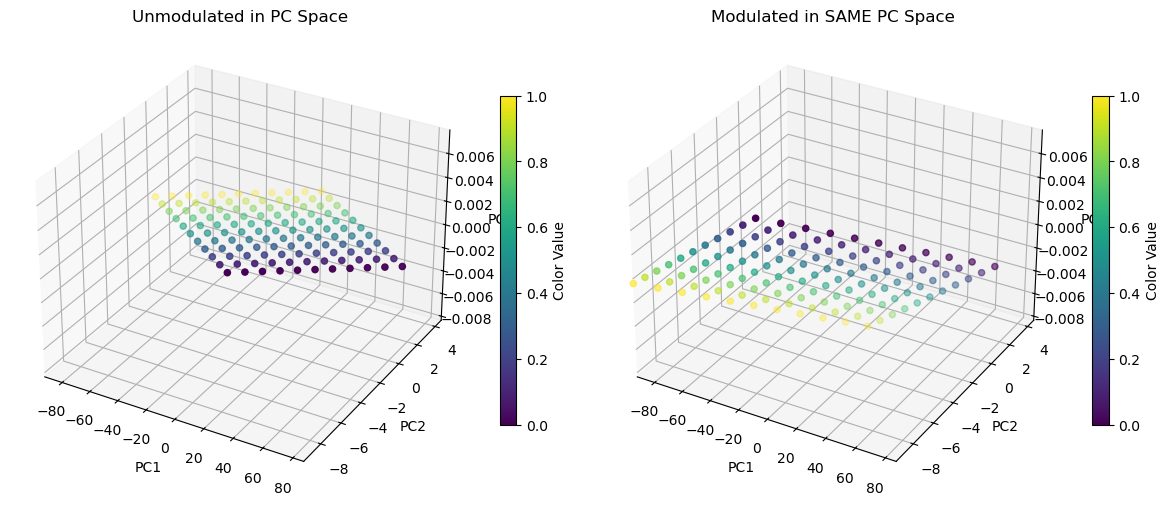

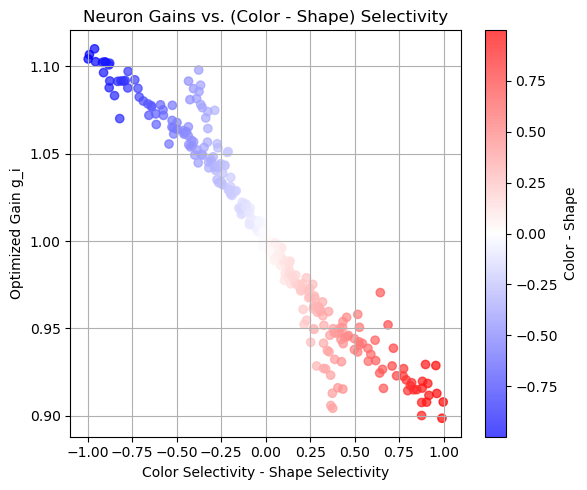

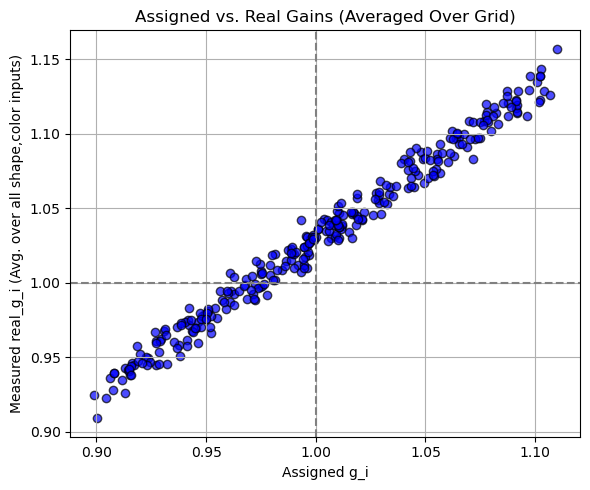

In [4]:
# ------------------------
# SNIPPET: Real g vs. Assigned g
# ------------------------

# 1) Compute the unmodulated grid responses [num_inputs, N]
r_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)

# 2) Compute the modulated grid responses [num_inputs, N]
r_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_opt)

# 3) Average over all inputs (axis=0 => average rows)
avg_unmod = np.mean(r_unmod, axis=0)  # shape [N,]
avg_mod   = np.mean(r_mod,   axis=0)  # shape [N,]

# 4) Compute real_g as ratio of mean modulated to mean unmodulated
#    If avg_unmod[i] is ~0, define real_g[i] as NaN
real_g = np.zeros_like(avg_unmod)
for i in range(len(avg_unmod)):
    if abs(avg_unmod[i]) < 1e-12:
        real_g[i] = np.nan
    else:
        real_g[i] = avg_mod[i] / avg_unmod[i]

# 5) Plot the assigned g vs. real_g
plt.figure(figsize=(6,5))
plt.scatter(g_opt, real_g, alpha=0.7, c='blue', edgecolors='k')
plt.axhline(1.0, color='gray', linestyle='--')
plt.axvline(1.0, color='gray', linestyle='--')

plt.xlabel("Assigned g_i")
plt.ylabel("Measured real_g_i (Avg. over all shape,color inputs)")
plt.title("Assigned vs. Real Gains (Averaged Over Grid)")
plt.grid(True)
plt.tight_layout()
plt.show()


RUNNING SLSQP WITH EQUALITY CONSTRAINT...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9999999972477942
            Iterations: 52
            Function evaluations: 5253
            Gradient evaluations: 52
Optimization done. success = True
Final objective: -0.9999999972477942
Initial color-axis norm = 51.3160
Final color-axis norm   = 51.3160 (difference: 1.8809e-09)
Angle pre-mod = 2.735 deg
Angle post-mod = 0.003 deg
Angle improvement = 2.732 deg


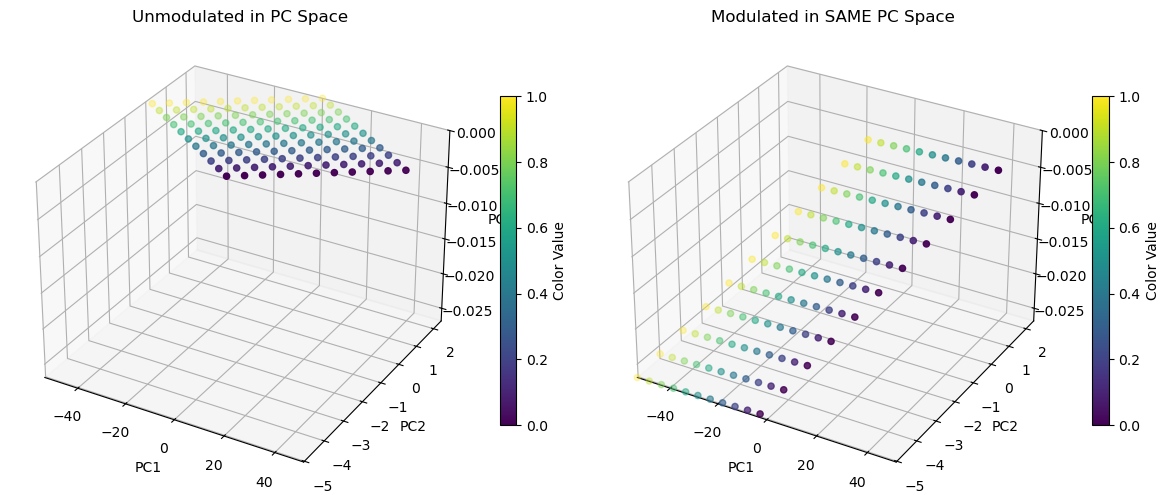

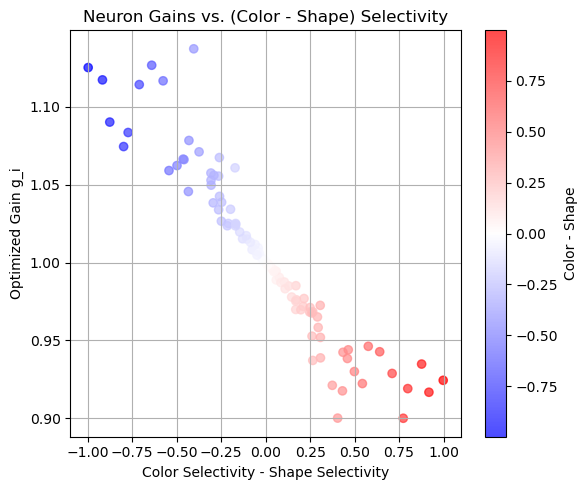

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(15)
N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# ================================================================
# MAIN SCRIPT
# ================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For coloring the grid in plots, we need to track the color param for each point
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [121,]

    # 2.1) Compute unmodulated responses for entire grid
    responses_grid_unmod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=None
    )
    # shape => [121, N]

    # 2.2) PCA on unmodulated grid responses, keep 3 PCs
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)  # shape = [121, N]
    pc_basis = pca_grid.components_  # shape [3, N]

    # We'll define v1 as the first PC (normalized)
    v1 = pc_basis[0]
    v1 /= np.linalg.norm(v1)

    # 3) For the color-axis alignment, pick shape=0.3
    shape_for_color_line = 0.3

    def color_axis_direction(g):
        """
        For a given g-vector, define color-axis as difference between
        response at color=1.0 and color=0.0 for shape=0.3.
        """
        resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
        resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
        return resp_c1 - resp_c0

    # 3.1) Compute unmodulated color axis (for norm reference):
    init_g = np.ones(N)
    d_unmod = color_axis_direction(init_g)
    norm_unmod_sq = np.linalg.norm(d_unmod)**2

    # 4) Objective: maximize cos^2 w.r.t. v1 => minimize negative cos^2
    def alignment_objective_angle_only(g):
        d_col = color_axis_direction(g)
        dot_val = np.dot(v1, d_col)
        denom = np.linalg.norm(d_col) * np.linalg.norm(v1)
        if denom < 1e-15:
            return 0.0  # degenerate
        cos_val = dot_val / denom
        # We want to maximize cos^2 => minimize the negative
        return -(cos_val**2)

    # 4.1) Exact constraint: keep ||d_col||^2 == ||d_unmod||^2
    def color_axis_norm_constraint(g):
        d_col = color_axis_direction(g)
        return np.linalg.norm(d_col)**2 - norm_unmod_sq

    # 5) Solve using SLSQP for exact equality + box constraints
    from scipy.optimize import Bounds

    L, U = 0.80, 1.20
    bounds = Bounds([L]*N, [U]*N)

    # We pass the constraint in the "dict" format recognized by SLSQP:
    constraint_eq = {
        'type': 'eq',
        'fun': color_axis_norm_constraint
    }

    print("RUNNING SLSQP WITH EQUALITY CONSTRAINT...")
    res = minimize(
        fun=alignment_objective_angle_only,
        x0=init_g,
        method='SLSQP',
        bounds=bounds,
        constraints=[constraint_eq],
        options={'maxiter': 300, 'disp': True}
    )

    g_opt = res.x
    print("Optimization done. success =", res.success)
    print("Final objective:", res.fun)

    # 5.1) Compare angles pre vs. post
    def angle_with_v1(d_vec):
        dot_v = np.dot(v1, d_vec)
        denom = np.linalg.norm(v1)*np.linalg.norm(d_vec)
        if denom < 1e-15:
            return np.nan
        val = dot_v / denom
        val = np.clip(val, -1, 1)
        angle_deg = np.degrees(np.arccos(val))
        # We'll consider 0 deg vs. 180 deg the same "axis" => pick smaller angle
        return min(angle_deg, 180.0 - angle_deg)

    d_mod = color_axis_direction(g_opt)
    angle_pre = angle_with_v1(d_unmod)
    angle_post = angle_with_v1(d_mod)

    # Check final norm
    final_norm = np.linalg.norm(d_mod)
    init_norm = np.sqrt(norm_unmod_sq)
    print(f"Initial color-axis norm = {init_norm:.4f}")
    print(f"Final color-axis norm   = {final_norm:.4f} (difference: {final_norm - init_norm:.4e})")

    print(f"Angle pre-mod = {angle_pre:.3f} deg")
    print(f"Angle post-mod = {angle_post:.3f} deg")
    print(f"Angle improvement = {angle_pre - angle_post:.3f} deg")

    # ---------------------------------------------------------
    # 6) Visualization
    #   6.1) 3D scatter: unmodulated vs modulated, each subplot in the same PC basis
    #   6.2) Another figure: (color_selectivity - shape_selectivity) vs. g_opt
    # ---------------------------------------------------------

    # 6.1) 3D scatter in the unmodulated PC space
    # Project the unmodulated grid responses and the modulated grid responses
    responses_grid_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=g_opt)
    proj_unmod = pca_grid.transform(responses_grid_unmod)  # shape [121, 3]
    proj_mod = pca_grid.transform(responses_grid_mod)      # shape [121, 3]

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Unmodulated in PC Space")
    sc1 = ax1.scatter(proj_unmod[:,0], proj_unmod[:,1], proj_unmod[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Modulated in SAME PC Space")
    sc2 = ax2.scatter(proj_mod[:,0], proj_mod[:,1], proj_mod[:,2],
                    c=color_list, cmap='viridis', s=20)
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")

    x_min = min(proj_unmod[:,0].min(), proj_mod[:,0].min())
    x_max = max(proj_unmod[:,0].max(), proj_mod[:,0].max())
    y_min = min(proj_unmod[:,1].min(), proj_mod[:,1].min())
    y_max = max(proj_unmod[:,1].max(), proj_mod[:,1].max())
    z_min = min(proj_unmod[:,2].min(), proj_mod[:,2].min())
    z_max = max(proj_unmod[:,2].max(), proj_mod[:,2].max())
    for ax in [ax1, ax2]:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

    cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
    cb1.set_label("Color Value")
    cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
    cb2.set_label("Color Value")

    plt.tight_layout()
    plt.show()

    # 6.2) Scatter: (color_selectivity - shape_selectivity) vs. g_opt
    color_diff = S[:,1] - S[:,0]

    fig2 = plt.figure(figsize=(6,5))
    plt.scatter(color_diff, g_opt, alpha=0.7, c=color_diff, cmap='bwr')
    plt.xlabel("Color Selectivity - Shape Selectivity")
    plt.ylabel("Optimized Gain g_i")
    plt.title("Neuron Gains vs. (Color - Shape) Selectivity")
    cb = plt.colorbar()
    cb.set_label("Color - Shape")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
